# Kinematic Control 1

*License: CC-BY-NC-SA 4.0*

*Author: Murilo M. Marinho (murilo.marinho@manchester.ac.uk)*

## Pre-requisites
The user of this notebook is expected to have prior knowledge in
- All the content and pre-requisites of lessons 1, 2, and 3.

## I found an issue
Thank you! Please report it at https://github.com/MarinhoLab/OpenExecutableBooksRobotics/issues

#### Latex Macros
$\providecommand{\myvec}[1]{{\mathbf{\boldsymbol{{#1}}}}}$
$\providecommand{\mymatrix}[1]{{\mathbf{\boldsymbol{{#1}}}}}$

# Pre-requisites

In [57]:
%%capture
%pip install numpy
%pip install numpy --break-system-packages

# Imports

In [58]:
import numpy as np
import spatialmath as sm
from math import pi, sin, cos

# 2 DoF planar robot (RR)

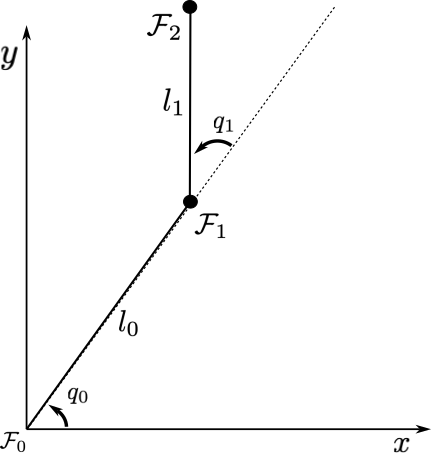

For the 2-DoF planar robot shown in the figure, let $q_0\triangleq q_0(t)$, $q_1\triangleq q_1(t)$, $l_{0}$, $l_{1} \in \mathbb{R}$ be the parameters to calculate

$$\mymatrix{H}^{0}_{2}( q_0, l_{0},q_1,l_{1}) \in SE(2),$$

that is, the forward kinematics model of the 2 DoF planar manipulator with configuration space given by 

$$\myvec{q} = \left[\begin{array}{ccc}
         q_0 \\
         q_1
        \end{array}\right].$$

and given the analytical Jacobian below

$$\dot{\myvec{x}}=\mymatrix{J} \dot{\myvec{q}}$$

where 

$$\myvec{x} = \left[\begin{array}{ccc}
         p_{x} \\
         p_{y} \\
         \phi_{z}
        \end{array}\right],$$

in which $p_{x}$, $p_{y}$, and $\phi_{z}$ are, respectively, the $x$-axis position, the $y$-axis position, and the $z$-axis angle of $\mathcal{F}_{2}$. Notice that $\dot{l}_{0}=\dot{l}_{1}=0$. 





### Consider the forward kinematics model calculated as in the past lesson

$$ \mymatrix{H}^{0}_{2} = \left[\begin{array}{ccc}
         \cos{(q_0 + q_1)} & -\sin{(q_0 + q_1)} & l_{0}\cos{q_0} + l_{1}\cos{(q_0 + q_1)}\\
         \sin{(q_0 + q_1)} & \cos{(q_0 + q_1)}  & l_{0}\sin{q_0} + l_{1}\sin{(q_0 + q_1)}\\
         0                 & 0                  & 1
        \end{array}\right].$$

which we turn into a function called `planar_robot_fkm` so that it can be easily reused

In [59]:
def planar_robot_fkm(q: np.array) -> np.array:
    """
    q: The configuration space values in radians.
    returns the x, this, the current task space value where x = [p_x p_y phi_z]^T.
    """
    l_0: float = 0.2 # The robot parameters. They don't change in time, so they are constant here.
    l_1: float = 0.1

    q_0 = q[0] # Just to make it more readable.
    q_1 = q[1] 

    p_x = l_0 * cos(q_0) + l_1 * cos(q_0 + q_1)
    p_y = l_0 * sin(q_0) + l_1 * sin(q_0 + q_1)
    phi_z = q_0 + q_1

    return np.array([p_x,
                     p_y,
                     phi_z])


### Consider the analytical Jacobian

We first calculate the Jacobian by hand, because programatically there's nothing for you to do yet. As we did in class, here is the Jacobian

$$\mymatrix{J} = \left[\begin{array}{ccc}
         -l_{0}\sin{q_0} - l_{1}\sin{(q_0 + q_1)} & -l_{1}\sin{(q_0 + q_1)} \\
         l_{0}\cos{q_0} + l_{1}\cos{(q_0 + q_1)} & l_{1}\cos{(q_0 + q_1)}  \\
         1                 & 1                  
        \end{array}\right].$$

We transform this Jacobian calculation into the function `planar_robot_jacobian` shown below

In [60]:
def planar_robot_jacobian(q: np.array) -> np.array: 
    """
    q: The configuration space values in radians.
    returns the 3x2 Jacobian mapping [q_0 q_1]^T to [px py phi_z]^T.
    """
    l_0: float = 0.2 # The robot parameters. They don't change in time, so they are constant here.
    l_1: float = 0.1

    q_0 = q[0] # Just to make it more readable.
    q_1 = q[1] 

    J_1_1 = -l_0 * sin(q_0) - l_1 * sin(q_0 + q_1)
    J_1_2 = -l_1 * sin(q_0  + q_1)
    J_2_1 =  l_0 * cos(q_0) + l_1 * sin(q_0 + q_1)
    J_2_2 =  l_1 * cos(q_0 +  q_1)
    J_3_1 = 1
    J_3_2 = 1

    return np.array(
                [[J_1_1, J_1_2],
                 [J_2_1, J_2_2],
                 [J_3_1, J_3_2]]
        )

## Kinematic Control

### 1. Define an error function

We usually use

$$\tilde{\myvec{x}}= \myvec{x} - \myvec{x}_d$$

that can be implemented as the function `get_error` below

In [61]:
def get_error(x: np.array, xd: np.array) -> np.array:
    """In this case, we use the difference as the error.
    x: current task-space vector.
    xd: desired task-space vector.
    """
    return x - xd

### 2. Define the controller step

We resort to the following control law

$$\myvec{u} = -\eta \mymatrix{J}^{\dagger}\tilde{\myvec{x}}$$

that can be easily implemented. Notice that we can resort to `np.linalg.pinv()` to perform the pseudo inversion.
We do so using all previous functions, combined into `planar_robot_kinematic_control_step()`.


In [62]:
def planar_robot_kinematic_control_step(q: np.array, xd : np.array) -> np.array:
    """
    q: The configuration space values in radians.
    xd: desired task-space vector.
    returns 'u', the control signal to move the robot one step towards the goal.
    """
    eta: float = 10 # This is usually a constant, so constant here

    # Calculate task-space value, x
    x = planar_robot_fkm(q)
    # Calculate task-space error, x_tilde
    x_tilde = get_error(x, xd)
    # Get the Jacobian
    J = planar_robot_jacobian(q)
    # Invert the Jacobian, for example, with numpy's implementation of it
    J_inv = np.linalg.pinv(J)

    return -eta * J_inv @ x_tilde

### Finally, the control loop

The idea here is to show that the norm of the error decreases with the control action. The desired task space vector will not always be achievable. Nonetheless, we can show, as below, that the control action reduces the task-space error, $\tilde{\myvec{x}}$.

In [ ]:
# A desired task-space value, defined by the problem at hand
xd = np.array([0.1,0.1,pi/10])
print(f"xd = {xd}")

# Define initial values for the joint positions
q_0 = 0.0
q_1 = 0.0
q = np.array([q_0,q_1])

# Define a stop criteria, in this case let's control for 10 seconds
t:float = 0 # Current time
T:float = 0.001 # Sampling time

print(f"Initial: q = {q}")
x = planar_robot_fkm(q)
print(f"Initial: x = {x}")
print(f"Initial: x_tilde_norm = {np.linalg.norm(get_error(x, xd))}")

while t < 10:
    u = planar_robot_kinematic_control_step(q, xd)
    q = q + u * T # Update law using the sampling time
    t = t + T
    
print(f"Final: q = {q}")
x = planar_robot_fkm(q)
print(f"Final: x = {planar_robot_fkm(q)}")
print(f"Final: x_tilde_norm = {np.linalg.norm(get_error(x, xd))}")

xd = [0.1        0.1        0.31415927]
initial q = [0. 0.]
initial x = [0.3 0.  0. ]
initial x_tilde_norm = 0.38561126022315995
final q = [ 2.03725132 -1.73623356]
final x = [0.00555896 0.20828287 0.30101777]
final x_tilde = 0.14428094004856512
